# Unmyelinated C-fiber model - convergence study

## Objectives
- Implement unmyelinated fiber model working with intracellular and extracellular current stimulation, as well as acoustic stimulation.
- Simulate the model upon intracellular current injection at the central node, for increasing spatial resolution (i.e. decreasing node length)
- Quantify the model convergence via 3 output metrics: stimulation threshold, conduction velocity and spike amplitude
- Evaluate the required spatial resolution (node length) to achieve a reliable convergence within a 5 % error margin (relative to maximal resolution).

## Rationale

An single-cable unmyelinated fiber model is constructed by simply setting internodal length to zero, and specifying fixing fiber length at instantiation. 
The number of nodes is derived from the required spatial resolution (i.e. the maximal node length), also specified at instantiation. 

Spatial resolution is expected to greatly affect simulations, since:
- low resolution could yield inaccurate simulation results (conduction velocity, spike amplitude), and eventually lead to action potential propagation failure 
- high resolution could induce a dramatic increase in computation time 

Therefore, we wish to find a trade-off in spatial resolution, with a node length small enough to produce accurate results, yet large enough to keep computation times reasonable. 

### Imports

In [11]:
import logging
import matplotlib.pyplot as plt
import numpy as np

from PySONIC.core import PulsedProtocol
from PySONIC.neurons import getPointNeuron
from PySONIC.utils import logger, si_format
from ExSONIC.core import IintraFiber, IntracellularCurrent, unmyelinatedFiber, unmyelinatedFiberConvergence, unmyelinatedFiberConvergence_fiberL
from ExSONIC.plt import SectionCompTimeSeries, strengthDurationCurve, plotConvergenceResults

logger.setLevel(logging.INFO)
%matplotlib notebook

## Default parameters

We use identical parameters as in the Sundt 2015 paper (0.8 um diameter, 5 mm long peripheral axon with fast Sodium, delayed-rectifier Potassium and leakage currents)

In [12]:
# Unmyelinated fiber model parameters
pneuron = getPointNeuron('sundt')          # C-fiber membrane equations
fiberD = 0.8e-6                            # peripheral axon diameter, from Sundt 2015 (m)
rs = 1e2                                   # axoplasm resistivity, from Sundt 2015 (Ohm.cm)
fiberL = 5e-3                              # axon length (m)
maxNodeL_range = np.logspace(-5, -3, 100)  # maximum node length range: from 10 um to 1 mm

# Stimulation parameters
tstim = 10e-6     # s
toffset = 20e-3  # s
pp = PulsedProtocol(tstim, toffset)

# Relative error threshold for convergence study
rel_eps_thr = 0.05

### Run convergence

 13/12/2019 11:44:17: running maxNodeL parameter sweep (10.00 um - 1.00 mm)
 13/12/2019 11:44:17: parameter sweep successfully completed
 13/12/2019 11:44:17: loading results from log file


<IPython.core.display.Javascript object>


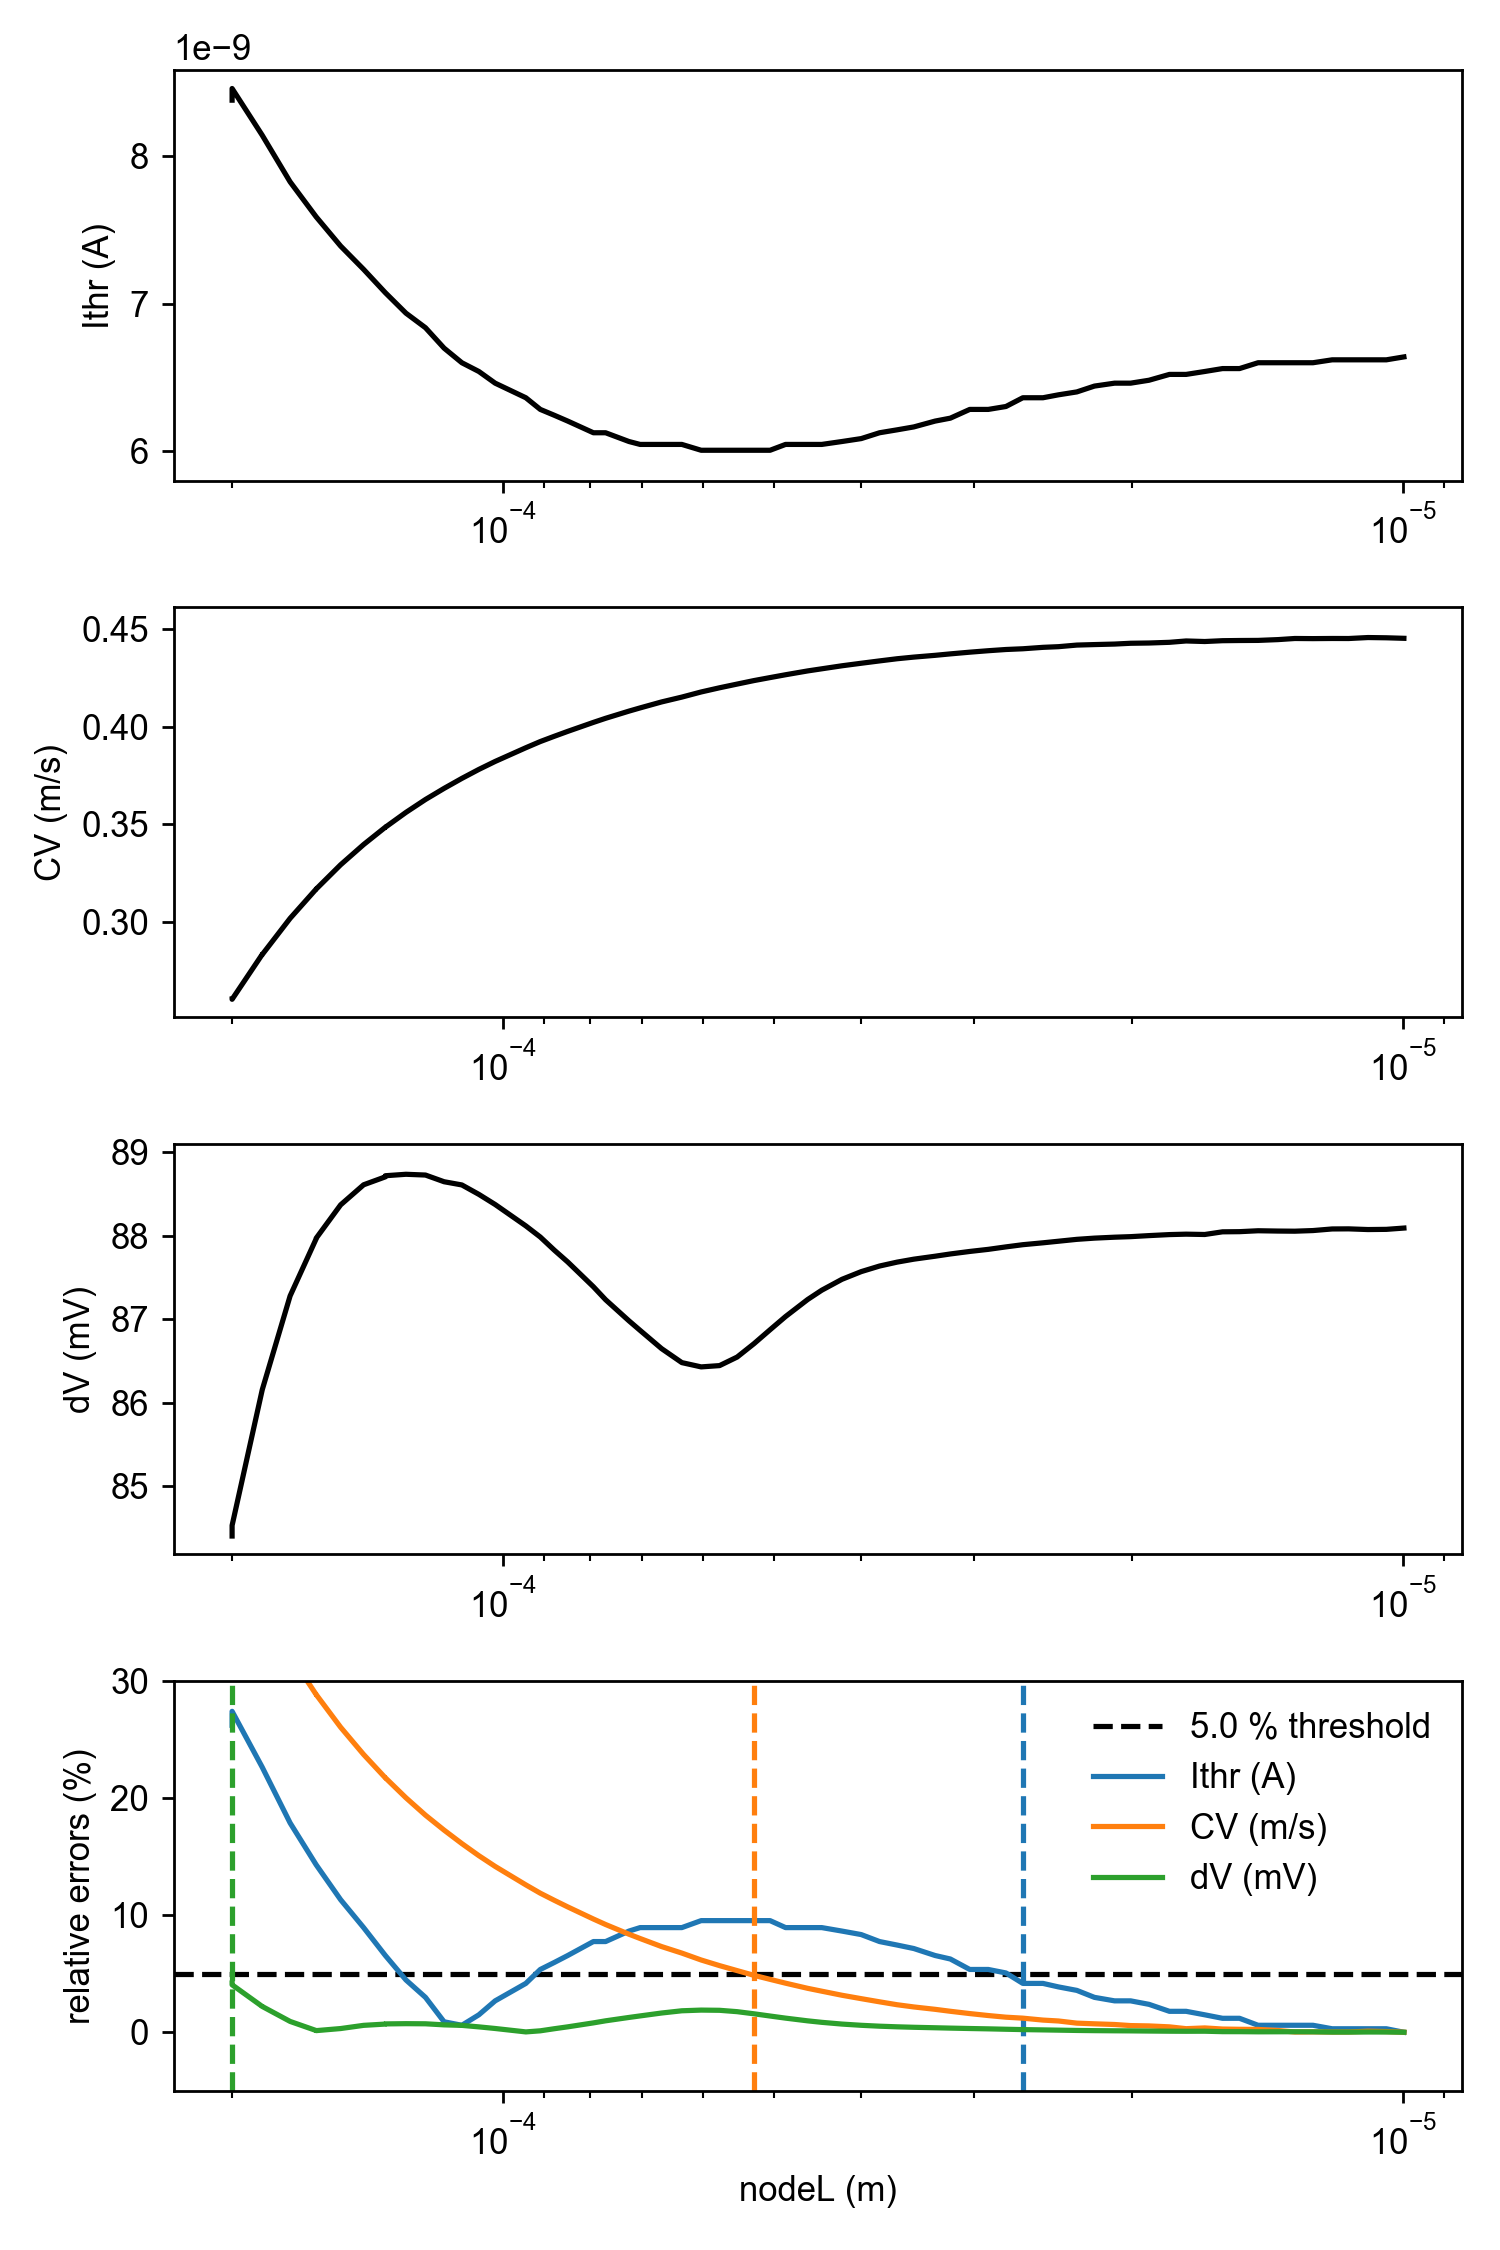

 13/12/2019 11:44:17: Relative error threshold = 5.0 %
 13/12/2019 11:44:17: Max nodeL (m) = 2.65e-05


In [6]:
df = unmyelinatedFiberConvergence(pneuron, fiberD, rs, fiberL, maxNodeL_range, pp, outdir='.')
_, inkey, *outkeys = list(df.columns)
%matplotlib notebook
fig = plotConvergenceResults(df, inkey, outkeys, rel_eps_thr=rel_eps_thr)

As we can see, as the node length is decreased, the 3 output metrics converge to specific asymptotic values:
- excitation threshold: 6.64 nA
- conduction velocity: 0.44 m/s
- spike amplitude: 88.1 mV

Setting a maximum relative error of 5%, we deduce that **a node length of around 26.5 um is required to achieve a reasonable accuracy**. Such a node length does not heavily compromise the computation time (model construction and simulation within a few seconds).

That number is in accordance (same order of magnitude) with the discretization strategy used in Sundt 2015 (100 segments for a 5 mm long peripheral axon, i.e. 50 um length per segment)

## Exploring other diameters

In order to make sure that our discretization threshold is robust, let us re-run the convergence study for other fiber diameters within the physiologically realistic range:

### 0.2 um diameter

 13/12/2019 14:57:54: running maxNodeL parameter sweep (5.00 um - 1.00 mm)
 13/12/2019 14:57:55: parameter sweep successfully completed
 13/12/2019 14:57:55: loading results from log file


<IPython.core.display.Javascript object>


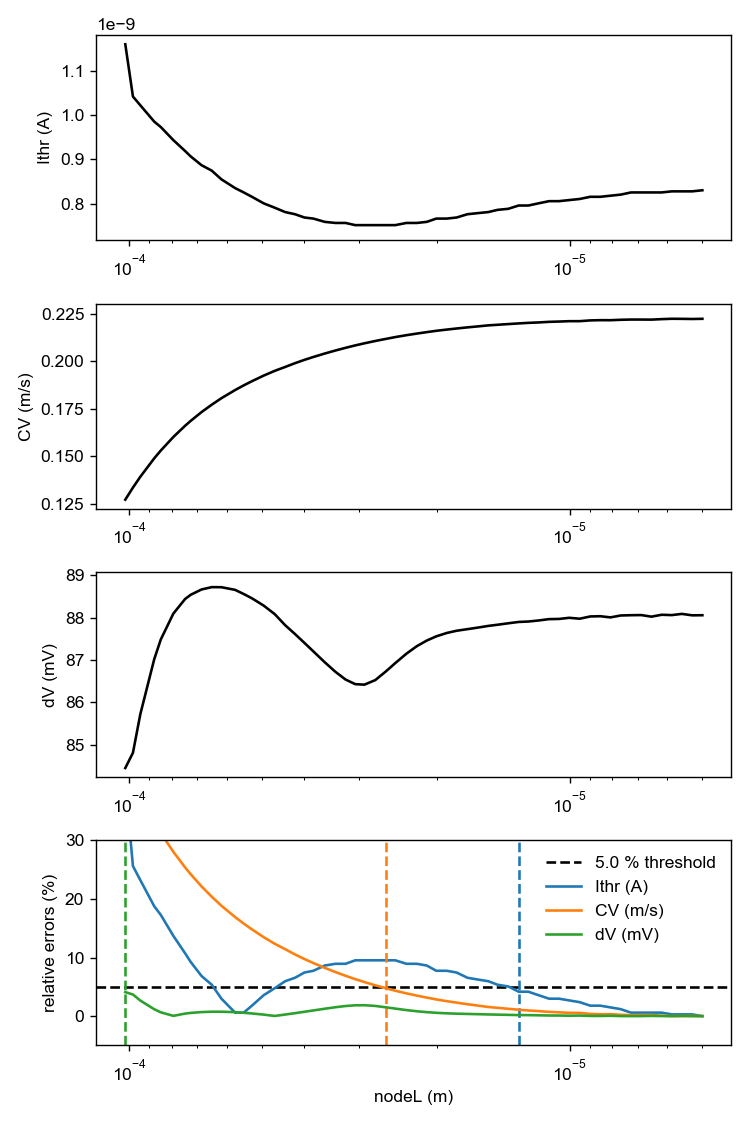

 13/12/2019 14:57:55: Relative error threshold = 5.0 %
 13/12/2019 14:57:55: Max nodeL (m) = 1.31e-05


In [10]:
maxNodeL_range = np.logspace(np.log10(5e-6), -3, 100)
fiberD = 0.2e-6  # (m)
df = unmyelinatedFiberConvergence(pneuron, fiberD, rs, fiberL, maxNodeL_range, pp, outdir='.')
_, inkey, *outkeys = list(df.columns)
%matplotlib notebook
fig = plotConvergenceResults(df, inkey, outkeys, rel_eps_thr=rel_eps_thr)

As the node length is decreased, the 3 output metrics converge to the asymptotic values:
- excitation threshold: 0.85 nA
- conduction velocity: 0.22 m/s
- spike amplitude: 88 mV

Decreasing the diameter, the excitation threshold decrease of one order of magnitude and the conduction velocity halves. The spike amplitude remain the same, and we could expect that the spike amplitude depends only on the point neuron model and not on the diameter. 

The node length required to achieve a reasonable accuracy is **17 um**: it becomes lower decreasing the fiber diameter.

### 1.5 um diameter

 13/12/2019 15:43:59: running maxNodeL parameter sweep (5.00 um - 1.00 mm)
 13/12/2019 15:43:59: parameter sweep successfully completed
 13/12/2019 15:43:59: loading results from log file


<IPython.core.display.Javascript object>


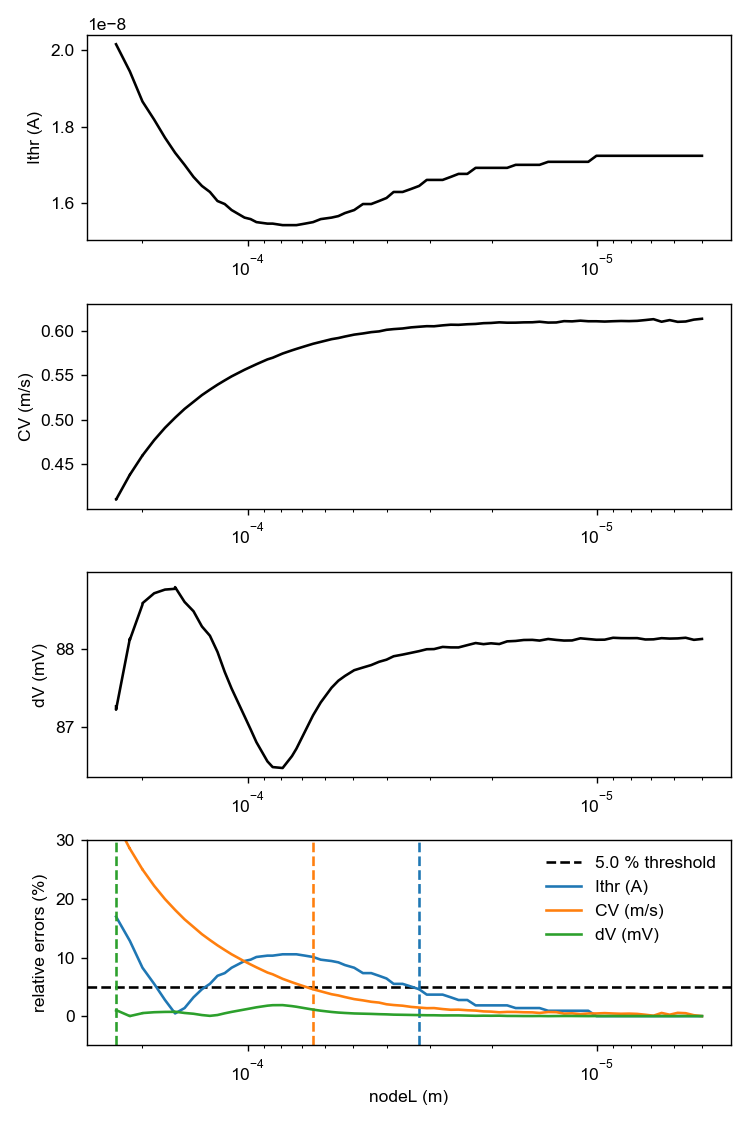

 13/12/2019 15:43:59: Relative error threshold = 5.0 %
 13/12/2019 15:43:59: Max nodeL (m) = 3.23e-05


In [23]:
fiberD = 1.5e-6  # (m)
maxNodeL_range = np.logspace(np.log10(5e-6), -3, 100)
df = unmyelinatedFiberConvergence(pneuron, fiberD, rs, fiberL, maxNodeL_range, pp, outdir='.')
_, inkey, *outkeys = list(df.columns)
fig = plotConvergenceResults(df, inkey, outkeys, rel_eps_thr=rel_eps_thr)

As the node length is decreased, the 3 output metrics converge to the asymptotic values:
- excitation threshold: 17.5 nA
- conduction velocity: 0.61 m/s
- spike amplitude: 88 mV

Increasing the diameter, the excitation threshold and the conduction velocity increase. The spike amplitude remain the same. 

The node length required to achieve a reasonable accuracy is **33 um**: it becomes higher increasing the fiber diameter.

Linear relation between nodelength_thrs and diameters (both in um): m = 12.1 and q = 15.0 um


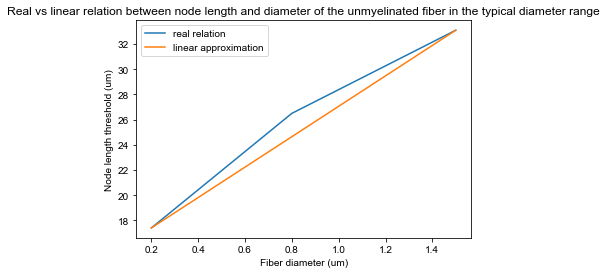

In [45]:
# Node length threshold / diameter relation found by previous convergence studies
diameters = [0.2, 0.8, 1.5]           #um
nodelength_thrs = [17.4, 26.5, 33.1]  #um

# Approximation with a linear relation
m_lin = (nodelength_thrs[2]-nodelength_thrs[0])/(diameters[2]-diameters[0])
q_lin = nodelength_thrs[0] - m_lin * diameters[0]    #um

plt.plot(diameters, nodelength_thrs, label = 'real relation')
plt.plot(diameters, m_lin * np.array(diameters) + q_lin, label = 'linear approximation')
plt.xlabel('Fiber diameter (um)')
plt.ylabel('Node length threshold (um)')
plt.legend()
plt.title('Real vs linear relation between node length and diameter '
          + 'of the unmyelinated fiber in the typical diameter range')
print (f'Linear relation between nodelength_thrs and diameters (both in um): ' 
       + f'm = {(m_lin):.1f} and q = {(q_lin):.1f} um')

Thanks to the results of the convergence studies for different diameters, we can extract a linear relation to approximate the relation between the node length required to achieve a relative error of 5% and the fiber diameter. The linear curve is under the real one, so the linear relation is more stringent. 

**node length thr (um)  =  fiber diameter (um) * 12.1  +  15.0 um**

We can set 50 um (the one used in Sundt paper) as upper end. So in the following studies we are going to use as maximum node length for the unmyelinated fiber the minimum between the nodel length thr (fiber diameter) from the linear relation and the sundt value. 

**max node length (um) = min (node length thr(fiber diameter), 50 um)**

<IPython.core.display.Javascript object>


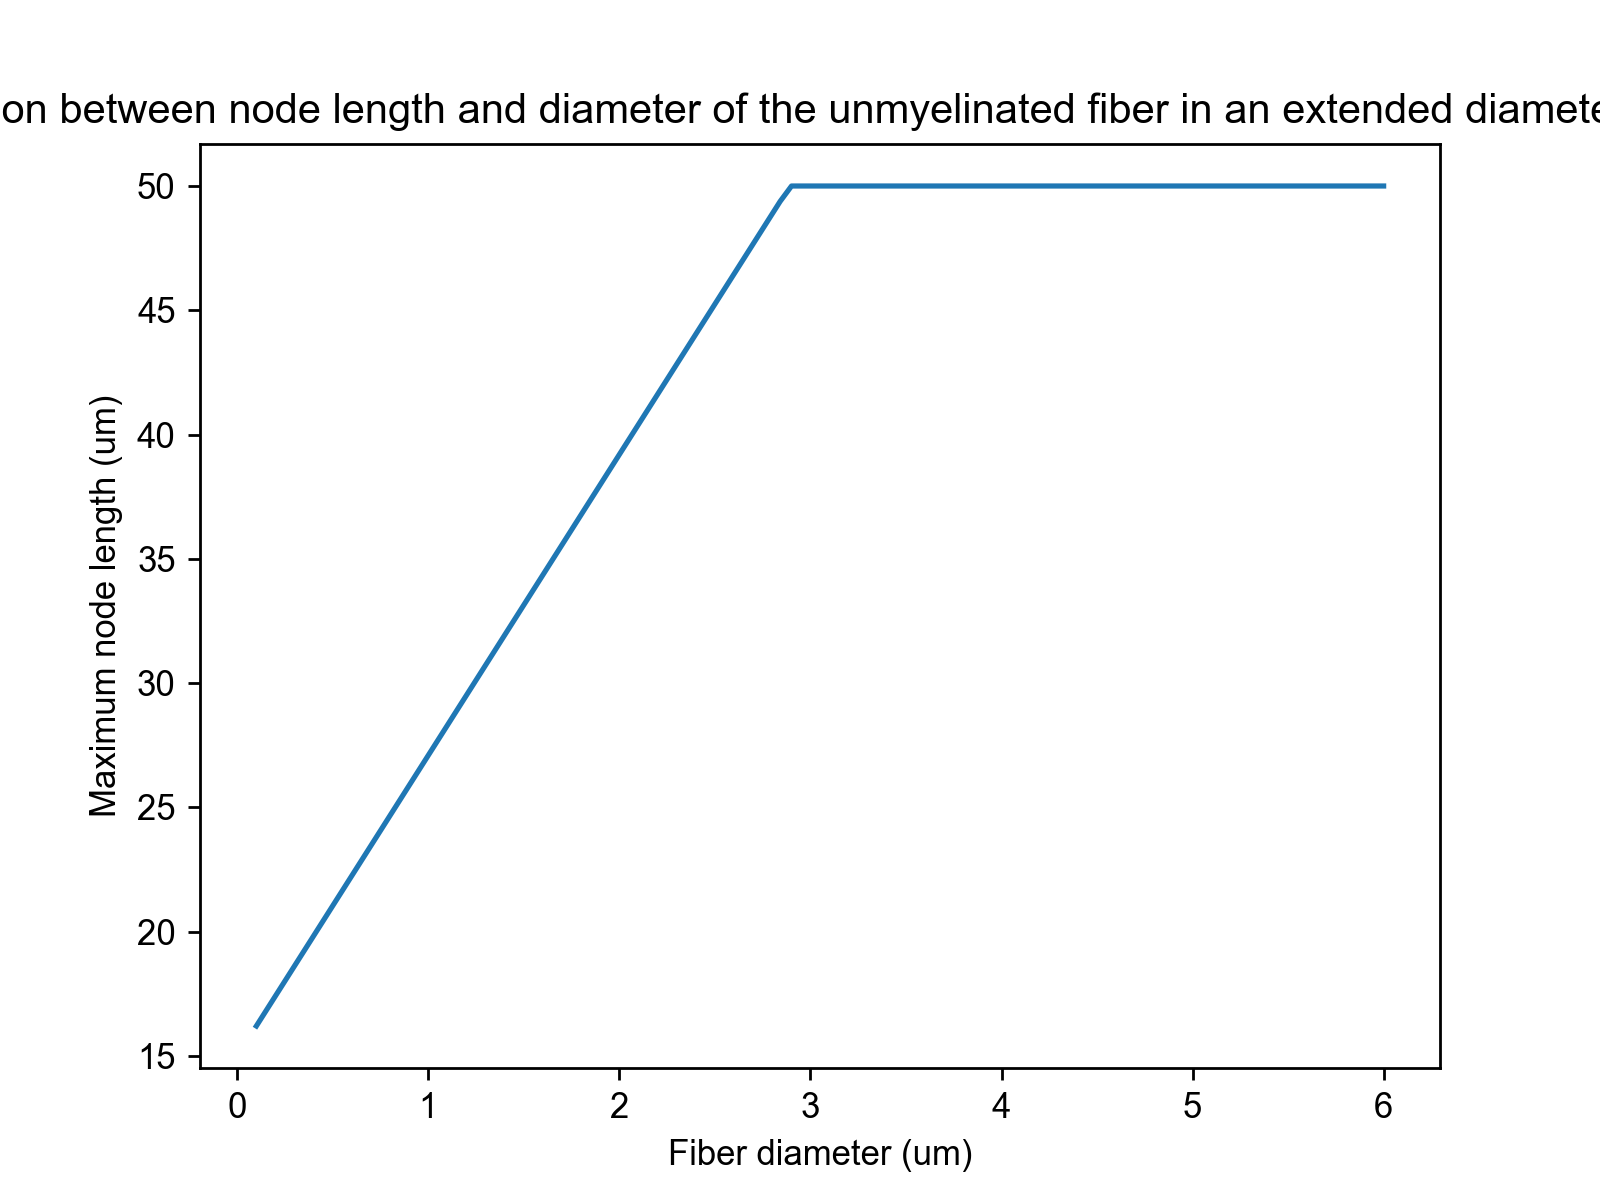

In [8]:
# Maximum node length computation
fiber_diameters = np.linspace(0.1, 6, 100)
nodelength_thr = fiber_diameters * 12.1 + 15.0  #um
max_nodelength = np.zeros(len(nodelength_thr))
for i, nlthr in enumerate(nodelength_thr):
    max_nodelength[i] = min(nlthr, 50)

plt.plot(fiber_diameters, max_nodelength)
plt.xlabel('Fiber diameter (um)')
plt.ylabel('Maximum node length (um)')
plt.title('Relation between node length and diameter ' 
          + 'of the unmyelinated fiber in an extended diameter range')
plt.show()

In the typical diameter range of the unmyelinated fibers [0.2, 1.5] um, the relationship is linear.

## Exploring other fiber lengths

The default fiber length is 5 mm.
In order to make sure that our discretization threshold is robust, let us re-run the convergence study for other fiber length.

### 0.2 um diameter

In [17]:
fiberD = 0.2e-6  # (m)
fiberL_range = np.logspace(np.log10(1e-4), np.log10(5e-3), 50)
df = unmyelinatedFiberConvergence_fiberL(pneuron, fiberD, rs, fiberL_range, pp, outdir='.')

 13/12/2019 15:11:31: running fiberL parameter sweep (100.00 um - 5.00 mm)
 13/12/2019 15:11:31: parameter sweep successfully completed
 13/12/2019 15:11:31: loading results from log file


<IPython.core.display.Javascript object>


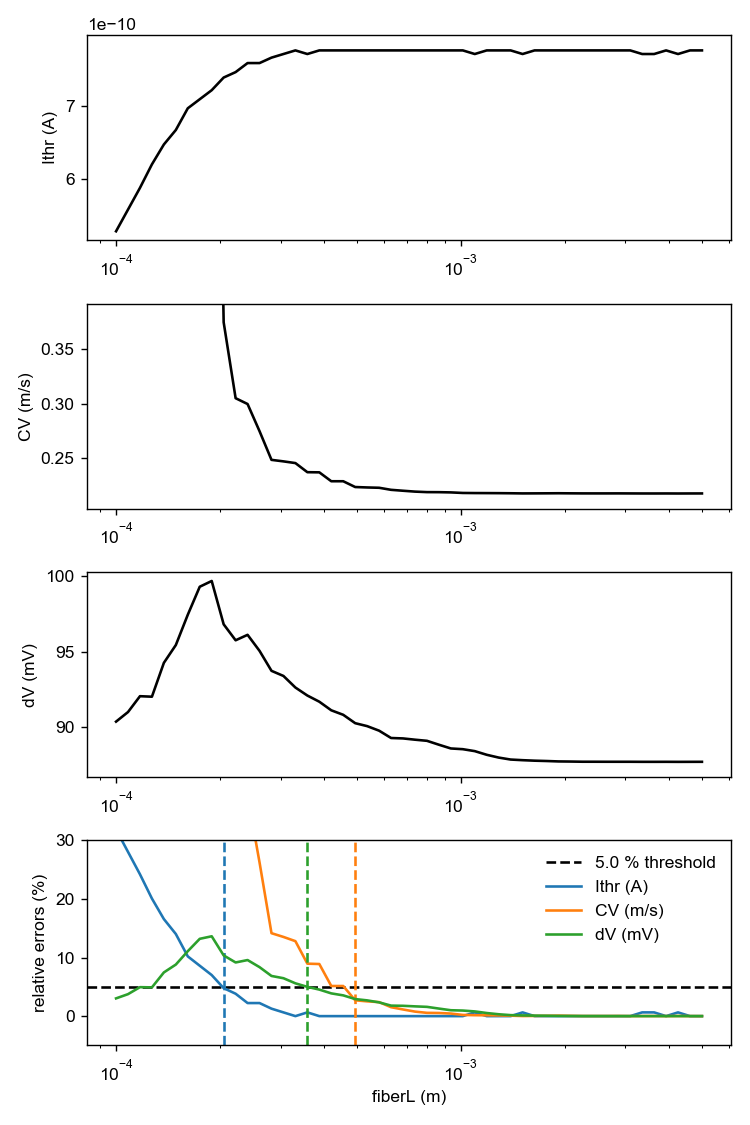

 13/12/2019 15:11:31: Relative error threshold = 5.0 %
 13/12/2019 15:11:31: Min fiberL (m) = 4.94e-04


In [18]:
%matplotlib notebook
inkey, _, *outkeys = list(df.columns)
fig = plotConvergenceResults(df, inkey, outkeys, rel_eps_thr=rel_eps_thr, axesdirection='a')

### 1.5 um diameter

In [19]:
fiberD = 1.5e-6  # (m)
fiberL_range = np.logspace(np.log10(1e-4), np.log10(5e-3), 50)
df = unmyelinatedFiberConvergence_fiberL(pneuron, fiberD, rs, fiberL_range, pp, outdir='.')

 13/12/2019 15:11:49: running fiberL parameter sweep (100.00 um - 5.00 mm)
 13/12/2019 15:11:49: parameter sweep successfully completed
 13/12/2019 15:11:49: loading results from log file


<IPython.core.display.Javascript object>


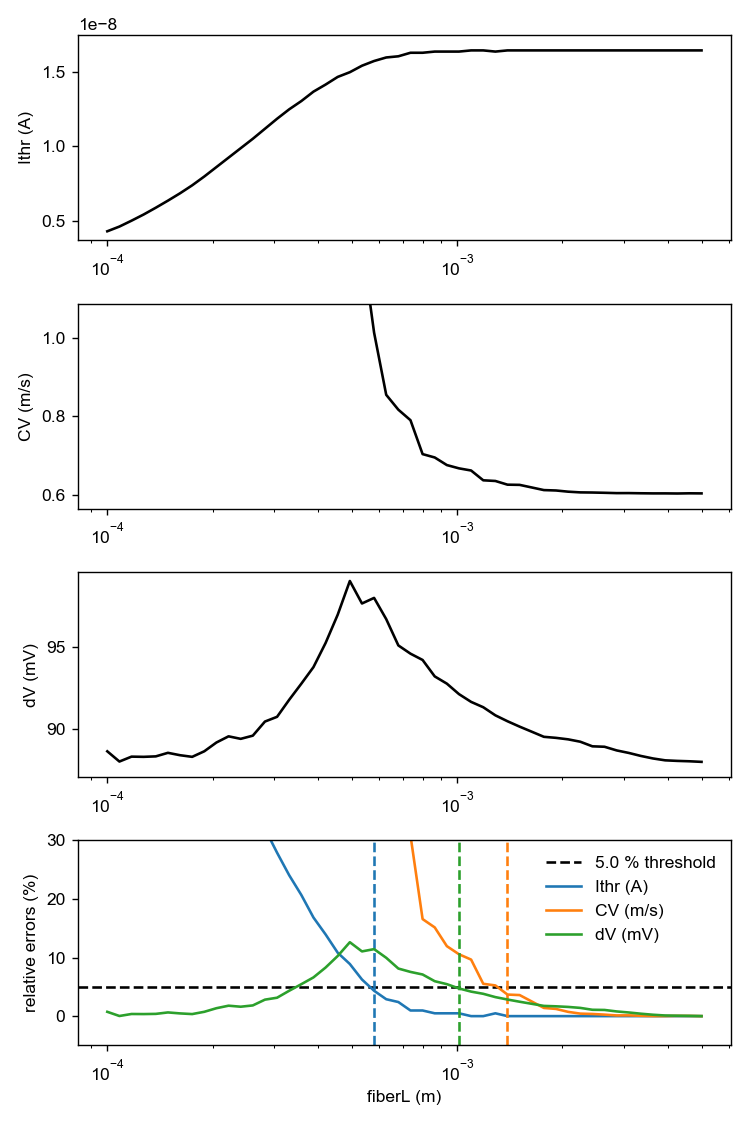

 13/12/2019 15:11:15: Relative error threshold = 5.0 %
 13/12/2019 15:11:15: Min fiberL (m) = 1.39e-03


In [16]:
%matplotlib notebook
inkey, _, *outkeys = list(df.columns)
fig = plotConvergenceResults(df, inkey, outkeys, rel_eps_thr=rel_eps_thr, axesdirection='a')

## Simulation with default parameters

In this section we run the simulation of the response of the typical Sundt fiber (parameters taken from the Sundt paper) with the node length and fiber length found with the convergence studies. 

The stimulation current applied has the amplitude 1.2 above the threshold value.

In [20]:
fiberD = 0.8e-6  # (m)
fiberL = 5000e-6    # her
fiber = unmyelinatedFiber(IintraFiber, pneuron, fiberD, rs, fiberL)
psource = IntracellularCurrent(fiber.nnodes // 2)
logger.info(f'Running titration for {si_format(pp.tstim)}s pulse')
logger.setLevel(logging.WARNING)
Ithr = fiber.titrate(psource, pp)  # A
logger.setLevel(logging.INFO)
data, meta = fiber.simulate(psource, 1.2*Ithr, pp)

 13/12/2019 15:12:28: Running titration for 10 us pulse
 13/12/2019 15:12:41: IintraFiber(sundt neuron, 203 nodes, rs = 100 Ohm.cm, nodeD = 800.0 nm, nodeL = 24.6 um, interD = 800.0 nm, interL = 0.0 m): simulation @ IntracellularCurrent(node 101), I = 7.66 nA, 10.0 us stim, 20.0 ms offset


<IPython.core.display.Javascript object>


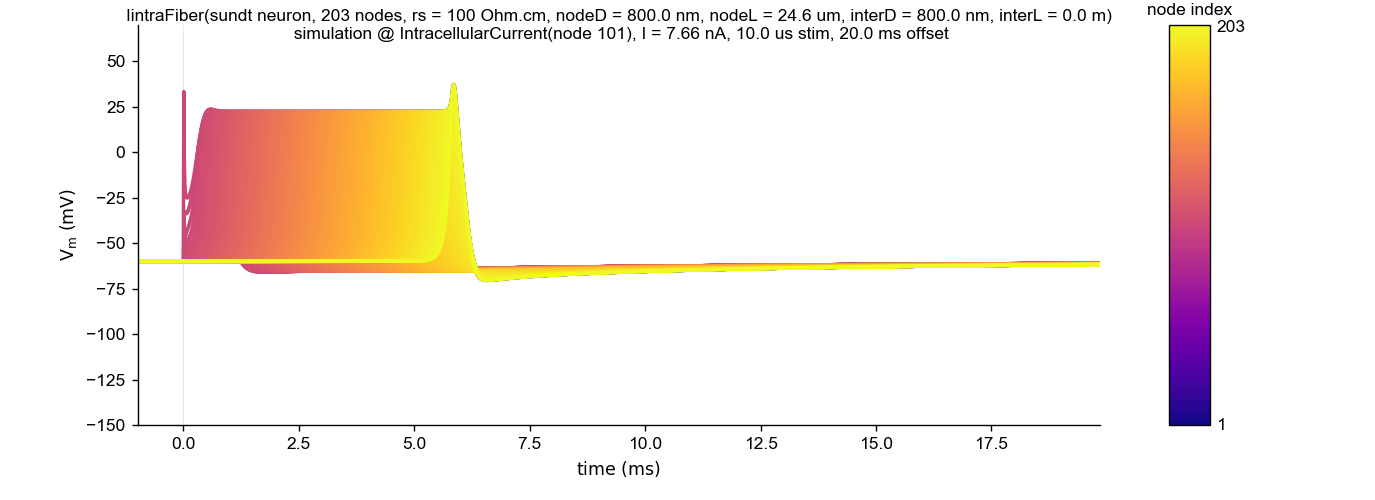

cv = 0.44 m/s
dV = 87.93 V


In [21]:
fig = SectionCompTimeSeries([(data, meta)], 'Vm', fiber.ids).render()
print(f'cv = {fiber.getConductionVelocity(data, out="median"):.2f} m/s')
print(f'dV = {fiber.getSpikeAmp(data, out="median"):.2f} V')

As we can see, the behavior of the unmyelinated C-fiber model is in good correspondence with the reference literature (Sundt 2015):
- conduction velocity is slightly slower than reported in the paper (0.54 m/s for the peripheral axon) but agrees with ModelDB simulation results
- action potential waveform (ca. 1-2 ms duration, ca. 87 mV amplitude) seems in line with the paper results
- the excitation threshold (0.12 nA) is in line with the just supra-threshold range of 0.2 nA used in the paper to stimulate the peripheral axon

## Strength-duration curve (to be removed from this notebook)
Let's compute the threshold injected current required to excite the fiber, for various stimulus durations:

In [12]:
fiber.reset()
durations = np.logspace(-5, -1, 10)  # s
logger.setLevel(logging.WARNING)
Ithrs = np.array([fiber.titrate(psource, PulsedProtocol(x, toffset)) for x in durations])
logger.setLevel(logging.INFO)

 25/11/2019 16:08:18: titration does not converge within this interval
 25/11/2019 16:08:24: titration does not converge within this interval


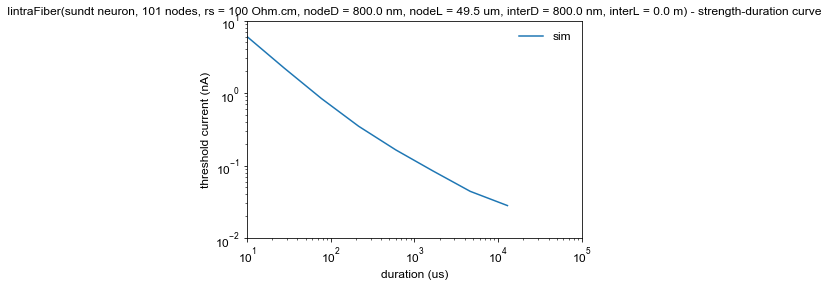

In [13]:
fig = strengthDurationCurve(
    fiber, durations, {'sim': np.array(Ithrs)}, scale='log', plot_chr=False,
    yname='current', yfactor=1e9, yunit='A')

Expectedly, the threshold current required to excite the fiber falls as the stimulus duration increases.

## Conclusions  (to be changed)
- The unmyelinated neuron fiber model is implemented
- A maximal node length of about **50 ${\mu}m$** is required to achieve accurate simulations (allowing for a 5% relative error in output metrics)
- Resulting conduction velocity is more than 10 times less than for myelinated fiber
- The strength-duration curve obtained from the simulation data makes empirical sense

## References

- Sundt D, Gamper N, Jaffe DB., *Spike propagation through the dorsal root ganglia in an unmyelinated sensory neuron: a modeling study*, J Neurophysiol 114: 3140–3153, 2015.